## Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [15]:
%matplotlib inline

In [16]:
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [17]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Summary:

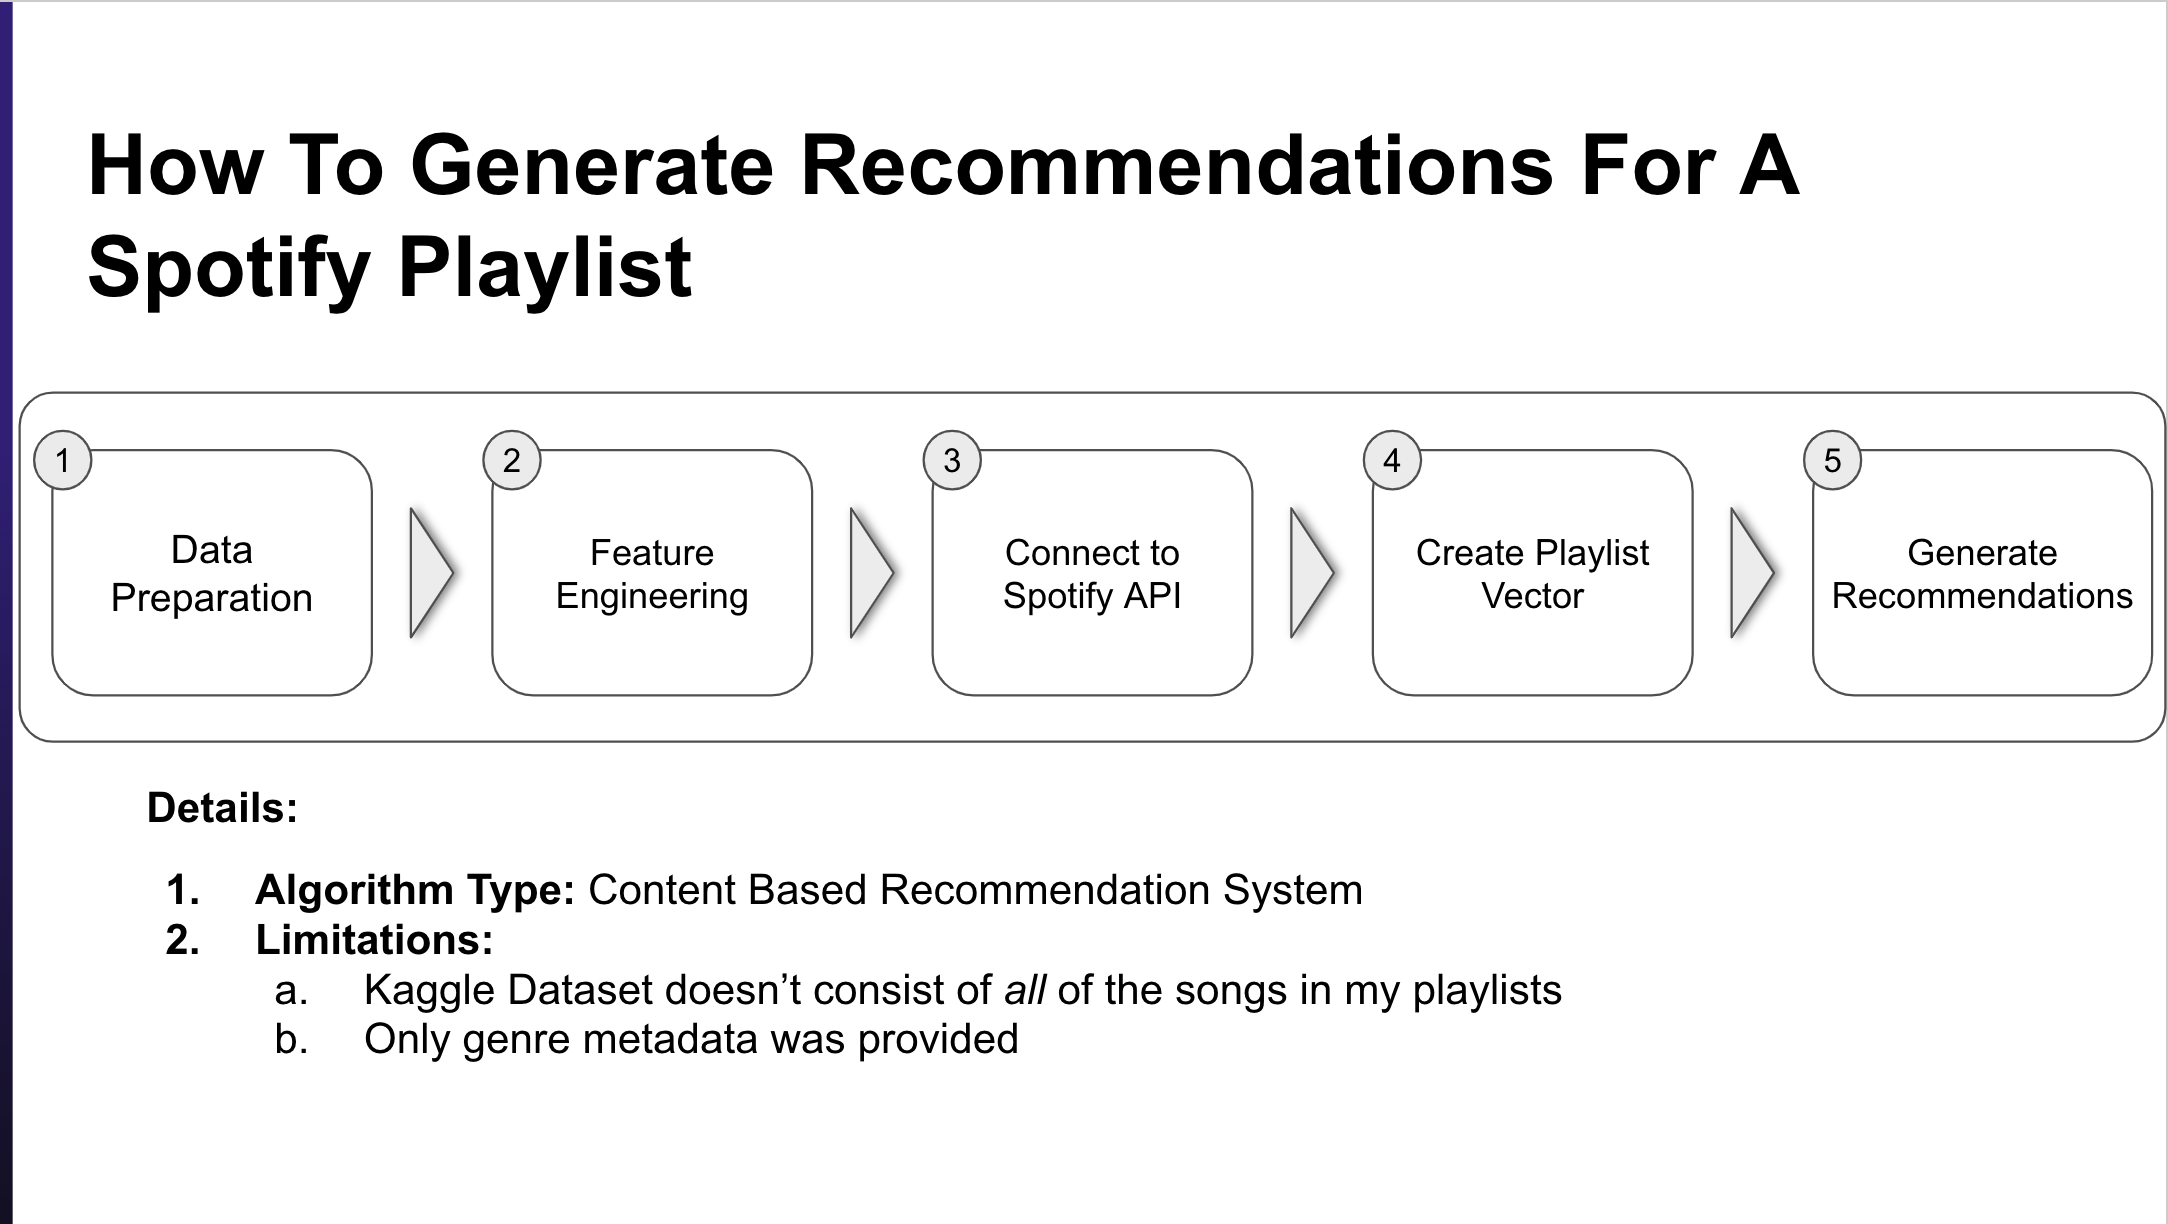

In [18]:
from IPython.display import Image
Image("C:/Users/Admin/Desktop/spotify-recommendation-system-main/process_2.png")

## 1. Data Exploration/Preparation

Download datasets here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [19]:
spotify_df = pd.read_csv('C:/Users/Admin/Desktop/spotify-recommendation-system-main/data.csv')

In [20]:
spotify_df.head()

acousticness                    artists  danceability  duration_ms  energy  \
0      0.991000            ['Mamie Smith']         0.598       168333   0.224   
1      0.643000  ["Screamin' Jay Hawkins"]         0.852       150200   0.517   
2      0.993000            ['Mamie Smith']         0.647       163827   0.186   
3      0.000173        ['Oscar Velazquez']         0.730       422087   0.798   
4      0.295000                   ['Mixe']         0.704       165224   0.707   

   explicit                      id  instrumentalness  key  liveness  \
0         0  0cS0A1fUEUd1EW3FcF8AEI          0.000522    5    0.3790   
1         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
2         0  11m7laMUgmOKqI3oYzuhne          0.000018    0    0.5190   
3         0  19Lc5SfJJ5O1oaxY0fpwfh          0.801000    2    0.1280   
4         1  2hJjbsLCytGsnAHfdsLejp          0.000246   10    0.4020   

   loudness  mode                                               name  \
0   -12.628     0                           Keep A Song In Your Soul   
1    -7.261     0                               I Put A Spell On You   
2   -12.098     1                                       Golfing Papa   
3    -7.311     1  True House Music - Xavier Santos & Carlos Gomi...   
4    -6.036     0                                          Xuniverxe   

   popularity release_date  speechiness    tempo  valence  year  
0          12         1920       0.0936  149.976   0.6340  1920  
1           7   1920-01-05       0.0534   86.889   0.9500  1920  
2           4         1920       0.1740   97.600   0.6890  1920  
3          17   1920-01-01       0.0425  127.997   0.0422  1920  
4           2   1920-10-01       0.0768  122.076   0.2990  1920

Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [21]:
data_w_genre = pd.read_csv('C:/Users/Admin/Desktop/spotify-recommendation-system-main/data_w_genres.csv')
data_w_genre.head()

artists  acousticness  \
0                   "Cats" 1981 Original London Cast      0.598500   
1                          "Cats" 1983 Broadway Cast      0.862538   
2        "Fiddler On The Roof” Motion Picture Chorus      0.856571   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.884926   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.510714   

   danceability    duration_ms    energy  instrumentalness  liveness  \
0      0.470100  267072.000000  0.376203          0.010261  0.283050   
1      0.441731  287280.000000  0.406808          0.081158  0.315215   
2      0.348286  328920.000000  0.286571          0.024593  0.325786   
3      0.425074  262890.962963  0.245770          0.073587  0.275481   
4      0.467143  270436.142857  0.488286          0.009400  0.195000   

    loudness  speechiness       tempo   valence  popularity  key  mode  count  \
0 -14.434300     0.209150  114.128800  0.358320   38.200000    5     1     10   
1 -10.690000     0.176212  103.044154  0.268865   31.538462    5     1     26   
2 -15.230714     0.118514   77.375857  0.354857   34.571429    0     1      7   
3 -15.639370     0.123200   88.667630  0.372030   34.407407    0     1     27   
4 -10.236714     0.098543  122.835857  0.482286   42.000000    5     1      7   

           genres  
0  ['show tunes']  
1              []  
2              []  
3              []  
4              []

Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [22]:
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

This checks whether or not `genres` is actually in a list format:

In [23]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [24]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [25]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [26]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Voila, now we have the genre column in a format we can actually use. If you go down, you'll see how we use it. 

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

Before I go further, let's complete these two steps.

Step 1. 
Similar to before, we will need to extract the artists from the string list. 

In [27]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [28]:
spotify_df['artists'].values[0]

"['Mamie Smith']"

In [29]:
spotify_df['artists_upd_v1'].values[0][0]

'Mamie Smith'

This looks good but did this work for every artist string format. Let's double check

In [30]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

acousticness                     artists  danceability  duration_ms  \
1          0.643   ["Screamin' Jay Hawkins"]         0.852       150200   
34         0.021  ["The Swingin' Bachelors"]         0.559       288293   
36         0.790  ["The Swingin' Bachelors"]         0.745       261013   
46         0.147  ["The Swingin' Bachelors"]         0.603       235547   
47         0.367  ["The Swingin' Bachelors"]         0.716       264240   

    energy  explicit                      id  instrumentalness  key  liveness  \
1    0.517         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
34   0.830         0  0bq1lNI8OPhdRQYZZSSnQk          0.146000   11    0.1870   
36   0.791         0  0e0zhCKclqwgJgA7Tjg2ca          0.000000    7    0.1020   
46   0.719         0  0xKe1lGyWBuk3lx3JIUUUx          0.000000    0    0.1110   
47   0.836         0  11rj3RWlVnnxW0EL7jwN8R          0.000006    9    0.1910   

    loudness  mode                   name  popularity release_date  \
1     -7.261     0   I Put A Spell On You           7   1920-01-05   
34    -7.876     0            Voodoo Doll           0   1920-02-29   
36    -8.584     1        Penticton Kitty           0   1920-02-29   
46    -5.464     0                Cloud 9           0   1920-02-29   
47    -6.099     1  Big Jim and the Twins           0   1920-02-29   

    speechiness    tempo  valence  year artists_upd_v1  
1        0.0534   86.889    0.950  1920             []  
34       0.0546  107.912    0.352  1920             []  
36       0.0595  120.169    0.658  1920             []  
46       0.0271   92.010    0.697  1920             []  
47       0.0451  105.986    0.635  1920             []

So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [31]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [32]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [33]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [34]:
spotify_df[spotify_df['name']=='Adore You']

acousticness           artists  danceability  duration_ms  energy  \
37846        0.1110   ['Miley Cyrus']         0.583       278747   0.655   
19696        0.0237  ['Harry Styles']         0.676       207133   0.771   
76258        0.0237  ['Harry Styles']         0.676       207133   0.771   

       explicit                      id  instrumentalness  key  liveness  \
37846         0  5AnCLGg35ziFOloEnXK4uu          0.000004    0     0.113   
19696         0  3jjujdWJ72nww5eGnfs2E7          0.000007    8     0.102   
76258         0  1M4qEo4HE3PRaCOM7EXNJq          0.000007    8     0.102   

       loudness  mode       name  popularity release_date  speechiness  \
37846    -5.407     1  Adore You          70   2013-10-04       0.0315   
19696    -3.675     1  Adore You          87   2019-12-13       0.0483   
76258    -3.675     1  Adore You          75   2019-12-06       0.0483   

         tempo  valence  year  artists_upd_v1 artists_upd_v2     artists_upd  \
37846  119.759    0.201  2013   [Miley Cyrus]             []   [Miley Cyrus]   
19696   99.048    0.569  2019  [Harry Styles]             []  [Harry Styles]   
76258   99.048    0.569  2019  [Harry Styles]             []  [Harry Styles]   

                artists_song  
37846   Miley CyrusAdore You  
19696  Harry StylesAdore You  
76258  Harry StylesAdore You

In [35]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [36]:
spotify_df[spotify_df['name']=='Adore You']

acousticness           artists  danceability  duration_ms  energy  \
37846        0.1110   ['Miley Cyrus']         0.583       278747   0.655   
19696        0.0237  ['Harry Styles']         0.676       207133   0.771   

       explicit                      id  instrumentalness  key  liveness  \
37846         0  5AnCLGg35ziFOloEnXK4uu          0.000004    0     0.113   
19696         0  3jjujdWJ72nww5eGnfs2E7          0.000007    8     0.102   

       loudness  mode       name  popularity release_date  speechiness  \
37846    -5.407     1  Adore You          70   2013-10-04       0.0315   
19696    -3.675     1  Adore You          87   2019-12-13       0.0483   

         tempo  valence  year  artists_upd_v1 artists_upd_v2     artists_upd  \
37846  119.759    0.201  2013   [Miley Cyrus]             []   [Miley Cyrus]   
19696   99.048    0.569  2019  [Harry Styles]             []  [Harry Styles]   

                artists_song  
37846   Miley CyrusAdore You  
19696  Harry StylesAdore You

Now I can explode this column and merge as I planned to in `Step 2`

In [37]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [38]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [39]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

Empty DataFrame
Columns: [artists_upd, id, artists, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence, popularity, key, mode, count, genres, genres_upd]
Index: []

Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [40]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [41]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [42]:
artists_genres_consolidated.head()

id                                         genres_upd  \
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_wave, new_wave_po...   
1  000Npgk5e2SgwGaIsN3ztv  [[classic_bollywood, classic_pakistani_pop, fi...   
2  000ZxLGm7jDlWCHtcXSeBe             [[boogie-woogie, piano_blues, stride]]   
3  000jBcNljWTnyjB4YO7ojf                                  [[bomba_y_plena]]   
4  000mGrJNc2GAgQdMESdgEc  [[classical, french_romanticism, late_romantic...   

                            consolidates_genre_lists  
0  [dance_rock, rock, new_wave, power_pop, new_wa...  
1  [filmi, sufi, classic_bollywood, classic_pakis...  
2               [piano_blues, stride, boogie-woogie]  
3                                    [bomba_y_plena]  
4  [historic_orchestral_performance, classical, l...

In [43]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

In [44]:
spotify_df.tail()

acousticness                                         artists  \
158279        0.0248                            ["Lil' Flip", 'Lea']   
158280        0.0249      ["World Class Wreckin' Cru", "Michel 'Le"]   
158281        0.9940  ["Vienna Boys' Choir", 'Uwe Christian Harrer']   
158282        0.0421                       ["Rappin' 4-Tay", 'Herm']   
158283        0.0113      ["Rappin' 4-Tay", 'MC Breed', 'Too $hort']   

        danceability  duration_ms  energy  explicit                      id  \
158279         0.814       225173  0.3870         1  4s0o8TJHfX9LLHa0umnOzT   
158280         0.715       351040  0.4900         0  3hoiinUc5VA9xUEJID7R8V   
158281         0.317        98000  0.0543         0  7GaUNnAdIMXrvYG7673QIK   
158282         0.893       232267  0.5770         0  0CHKRuAjf8LvCL6SxCnq7V   
158283         0.897       337973  0.4140         1  78859Af0fmA9VTlgnOHTAP   

        instrumentalness  key  liveness  loudness  mode  \
158279          0.000000    0     0.131    -9.867     1   
158280          0.000170    9     0.139    -9.504     0   
158281          0.027700   10     0.168   -23.239     1   
158282          0.000177    7     0.119    -7.311     1   
158283          0.000110    4     0.101    -8.450     0   

                             name  popularity release_date  speechiness  \
158279       Sunshine (feat. Lea)          61   2004-03-30       0.0945   
158280  Turn Off The Lights - Rap          35   1994-04-06       0.0479   
158281               O Tannenbaum          45   1996-01-01       0.0777   
158282          Playa of the Year           0   1999-09-17       0.1850   
158283            Never Talk Down          35         1996       0.2460   

          tempo  valence  year     artists_upd_v1  \
158279   93.961    0.792  2004         [ Flip", ]   
158280  129.309    0.429  1994  [ Cru", "Michel ]   
158281   81.111    0.290  1996        [ Choir", ]   
158282   93.000    0.572  1999        [ 4-Tay", ]   
158283   96.039    0.273  1996    [ 4-Tay", , , ]   

                                artists_upd_v2        artists_upd  \
158279                             [Lil' Flip]         [ Flip", ]   
158280  [World Class Wreckin' Cru, Michel 'Le]  [ Cru", "Michel ]   
158281                    [Vienna Boys' Choir]        [ Choir", ]   
158282                         [Rappin' 4-Tay]        [ 4-Tay", ]   
158283                         [Rappin' 4-Tay]    [ 4-Tay", , , ]   

                                    artists_song consolidates_genre_lists  
158279               Flip", Sunshine (feat. Lea)                      NaN  
158280   Cru", "Michel Turn Off The Lights - Rap                      NaN  
158281                      Choir", O Tannenbaum                      NaN  
158282                 4-Tay", Playa of the Year                      NaN  
158283                   4-Tay", Never Talk Down                      NaN

In [45]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [46]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [47]:
ohe_cols = 'popularity'

In [48]:
spotify_df['popularity'].describe()

count    158284.000000
mean         25.765175
std          21.732005
min           0.000000
25%           1.000000
50%          26.000000
75%          42.000000
max         100.000000
Name: popularity, dtype: float64

In [49]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [50]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [51]:
spotify_df.head()

acousticness                  artists  danceability  duration_ms  energy  \
0         0.568                  ['조정현']         0.447       237688   0.215   
1         0.939  ['김효근', 'Quinever 퀸에버']         0.174       341821   0.321   
2         0.509                  ['김수철']         0.456       189245   0.321   
3         0.134                  ['龔詩嘉']         0.450       184120   0.782   
4         0.381                   ['黑豹']         0.353       316160   0.686   

   explicit                      id  instrumentalness  key  liveness  \
0         0  2ghebdwe2pNXT4eL34T7pW          0.000001   10    0.0649   
1         0  6ra76urfo3pTD050opXTZS          0.756000    3    0.6950   
2         0  4FG1uHQAVPsYiXIn3tcGRs          0.000001    4    0.1560   
3         0  2w5L5kQVkSRdduNewYPDA5          0.000000    0    0.0632   
4         0  3KIuCzckjdeeVuswPo20mC          0.000000   11    0.0568   

   loudness  mode                               name  popularity release_date  \
0   -16.478     1                         그아픔까지사랑한거야          30   1989-06-15   
1   -13.411     1  Promise of Thousand Years 천 년의 약속           0   2019-10-18   
2   -16.682     0                           못다핀 꽃한송이          24   1983-08-15   
3    -5.905     1                     My Island Home          17   2015-07-31   
4    -9.103     1               DON'T BREAK MY HEART          34   1992-12-22   

   speechiness    tempo  valence  year       artists_upd_v1 artists_upd_v2  \
0       0.0272   71.979   0.1770  1989                [조정현]             []   
1       0.0422  138.300   0.0554  2019  [김효근, Quinever 퀸에버]             []   
2       0.0314   79.114   0.2100  1983                [김수철]             []   
3       0.0306   87.980   0.4750  2015                [龔詩嘉]             []   
4       0.0395  200.341   0.3520  1992                 [黑豹]             []   

           artists_upd                          artists_song  \
0                [조정현]                         조정현그아픔까지사랑한거야   
1  [김효근, Quinever 퀸에버]  김효근Promise of Thousand Years 천 년의 약속   
2                [김수철]                           김수철못다핀 꽃한송이   
3                [龔詩嘉]                     龔詩嘉My Island Home   
4                 [黑豹]                黑豹DON'T BREAK MY HEART   

                  consolidates_genre_lists  popularity_red  
0                     [classic_korean_pop]               6  
1                                       []               0  
2                     [classic_korean_pop]               4  
3  [singaporean_pop, singaporean_mandopop]               3  
4      [chinese_indie, chinese_indie_rock]               6

In [52]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


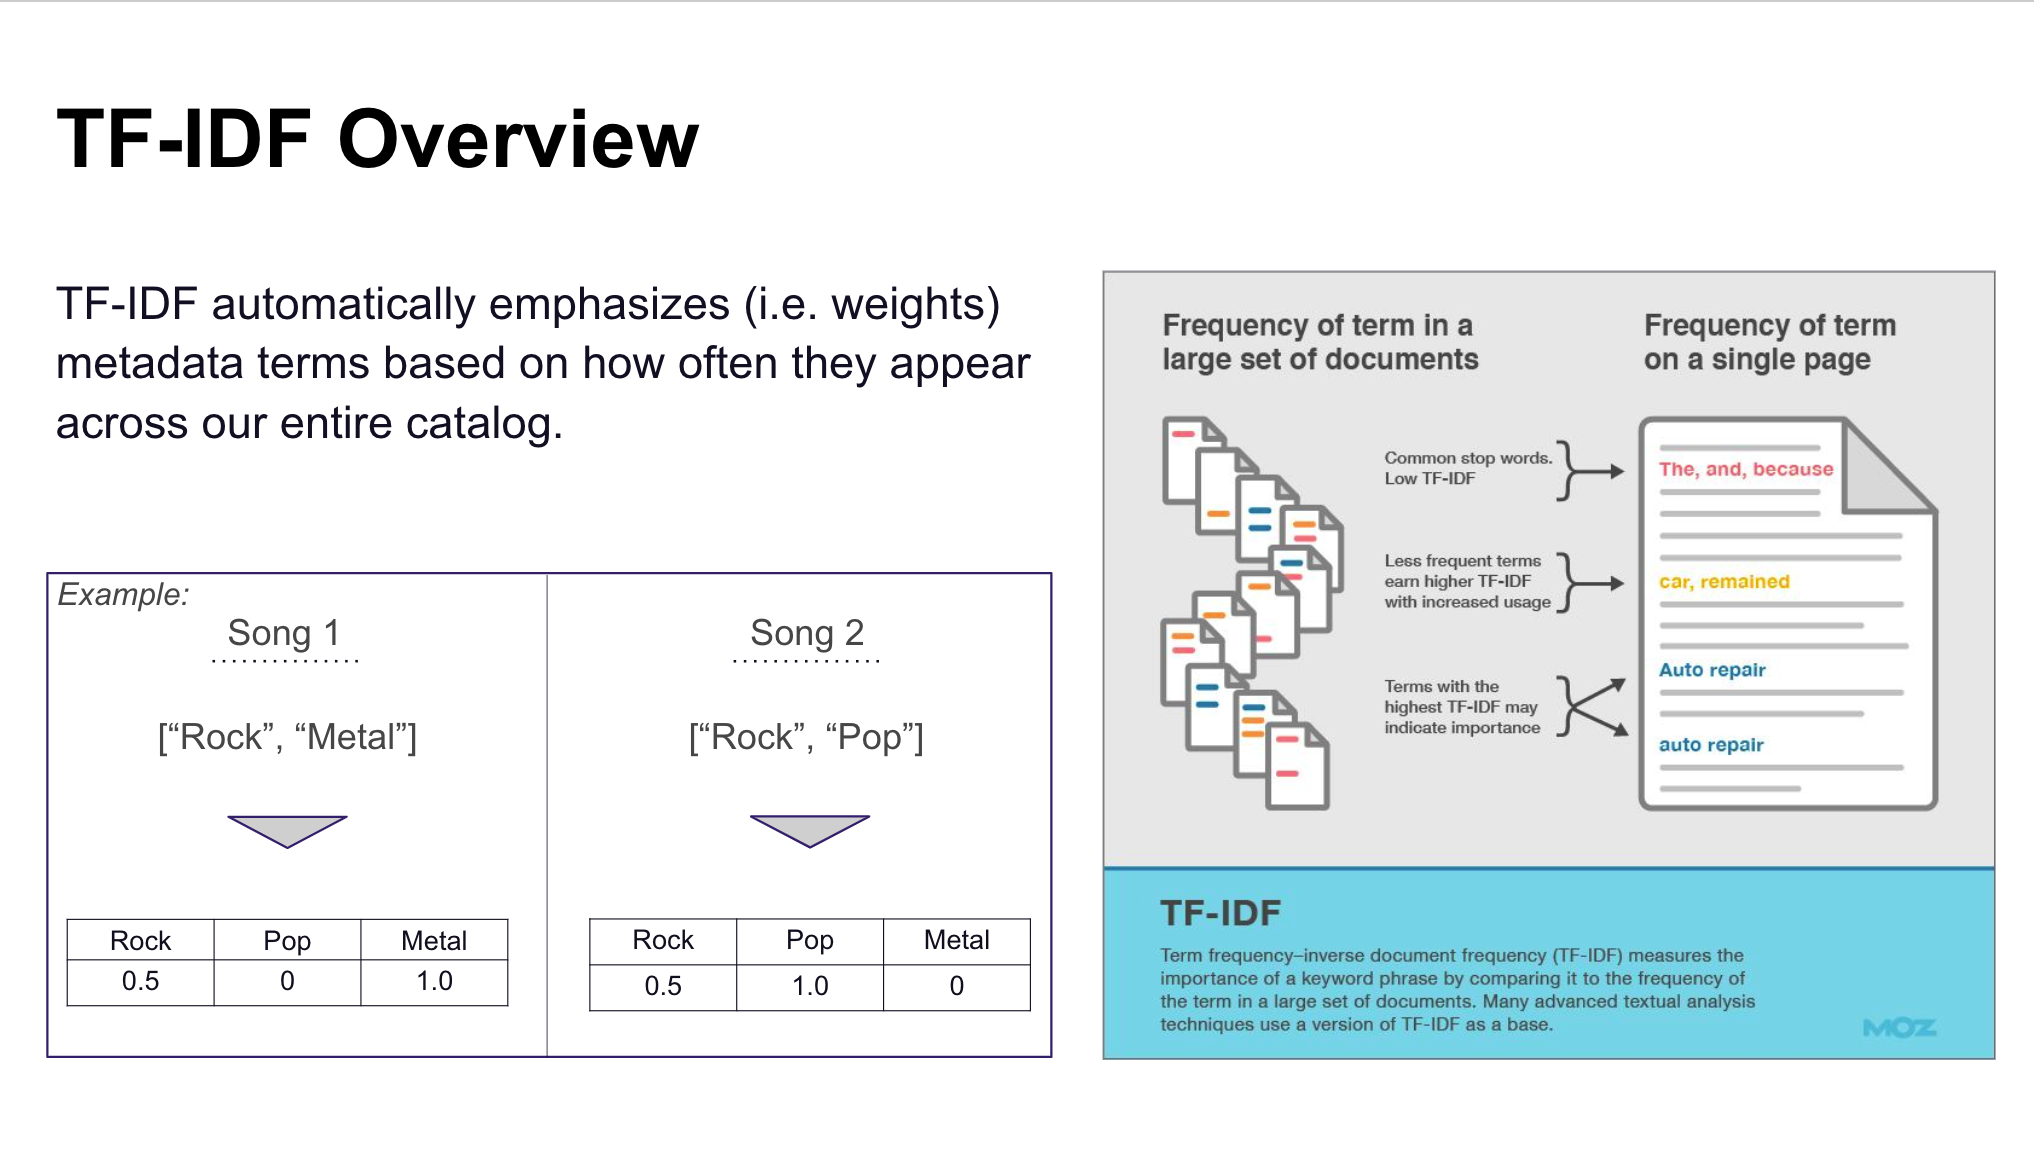

In [53]:
from IPython.display import Image
Image("C:/Users/Admin/Desktop/spotify-recommendation-system-main/tfidf_4.png")

In [54]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [55]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [56]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|abstract_idm  genre|accordeon  \
0                     0.0                 0.0              0.0   
1                     0.0                 0.0              0.0   
2                     0.0                 0.0              0.0   
3                     0.0                 0.0              0.0   
4                     0.0                 0.0              0.0   

   genre|accordion  genre|acid_house  genre|acid_jazz  genre|acid_rock  \
0              0.0               0.0              0.0              0.0   
1              0.0               0.0              0.0              0.0   
2              0.0               0.0              0.0              0.0   
3              0.0               0.0              0.0              0.0   
4              0.0               0.0              0.0              0.0   

   genre|acid_techno  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0                0.0                0.0               0.0             0.0   
1                0.0                0.0               0.0             0.0   
2                0.0                0.0               0.0             0.0   
3                0.0                0.0               0.0             0.0   
4                0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_chill  genre|acoustic_guitar_cover  \
0                   0.0                   0.0                          0.0   
1                   0.0                   0.0                          0.0   
2                   0.0                   0.0                          0.0   
3                   0.0                   0.0                          0.0   
4                   0.0                   0.0                          0.0   

   genre|acoustic_pop  genre|acoustic_punk  genre|acoustic_rock  \
0                 0.0                  0.0                  0.0   
1                 0.0                  0.0                  0.0   
2                 0.0                  0.0                  0.0   
3                 0.0                  0.0                  0.0   
4                 0.0                  0.0                  0.0   

   genre|action_rock  genre|adoracao  genre|adoracion  genre|adult_standards  \
0                0.0             0.0              0.0                    0.0   
1                0.0             0.0              0.0                    0.0   
2                0.0             0.0              0.0                    0.0   
3                0.0             0.0              0.0                    0.0   
4                0.0             0.0              0.0                    0.0   

   genre|adventista  genre|afghan_pop  genre|afghan_traditional  \
0               0.0               0.0                       0.0   
1               0.0               0.0                       0.0   
2               0.0               0.0                       0.0   
3               0.0               0.0                       0.0   
4               0.0               0.0                       0.0   

   genre|african  genre|african_gospel  genre|african_percussion  \
0            0.0                   0.0                       0.0   
1            0.0                   0.0                

## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [2]:
#client id and secret for my application
client_id = 'c83a7a91bb4743aaaaae481d65b7debd'
client_secret= '00d515ff335748fb89db2ad7a7416e40'

In [3]:
scope = 'user-library-read playlist-read-private user-read-recently-played user-top-read user-read-playback-position playlist-modify-public playlist-modify-private playlist-read-private playlist-read-collaborative user-library-modify user-library-read'

username = sys.argv[0]

In [4]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [5]:
token = "BQB3e96tbdLYNk9ATyfdmIuFSItjik1Jj1kDTaP6e1mfQqThgjKpgQWGM15Abqm3xHOlPN3I08_q9yDB2pmLs6OACdCKMXGGXsqoDFyTErI6TcocVtS-UDxscBkXs13ouEizFLHcOQ3KF3M5_NigAWAyg7eJUY9F3ej0LL38zHN4q7bM6bVw7juxhvPpPYwvE_UiVTHsAb7_1Dv28FHNBxKzrgy4po-5x-5tIXVVVmxsAWPUFuTS7zRZVdHxHnN0md7wv6P2srg_6oD2FX8Psi501ti-gSOv0YuKOEb8xDtY6nf1"

In [6]:
sp = spotipy.Spotify(auth=token)

In [7]:

#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [8]:
id_name

{'Waa': '4MXiqn1NegeSJSqqWg6fun',
 'EDM': '1VcF4XtQGPYYTyEPzhEXlc',
 'Chill': '6XHAHPsqu55RlZ67SYfZHL',
 'Weeb': '13JrBviqnX0wQ8oeDcTklE',
 'Reflections': '7BiQ6mW9XdEjvb11oTVkIH',
 'EPIC VIOLIN': '5fDy2LILGKTCo8froLBAfD',
 'Lordlly': '25NhK0h95uIqNADT2GgSJg',
 'Neo Soul': '0y4bvz4wEaqwl8ENcBPzPh'}

In [63]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [95]:
res = list(id_name.keys())[0]
res

'Weeb'

In [92]:
getname ={}
for i in id_name.items():
    getname = i[0]
    getname

In [93]:
getname

'Neo Soul'

In [96]:
playlist_EDM = create_necessary_outputs('EDM', id_name,spotify_df)
playlist_chill = create_necessary_outputs('Reflections',id_name, spotify_df)

In [97]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [98]:
playlist_chill

artist                            name                      id  \
6  Anamanaguchi                            Miku  2wxeIeofgy4AHaOhtePamJ   
4      Ashnikko  Daisy 2.0 (feat. Hatsune Miku)  0s8RXkQW9lwGEV6WlG8KDq   

                                                 url                date_added  
6  https://i.scdn.co/image/ab67616d00001e02d03049... 2021-05-19 10:05:22+00:00  
4  https://i.scdn.co/image/ab67616d00001e02506436... 2021-05-19 10:05:10+00:00

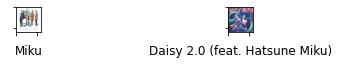

In [99]:
visualize_songs(playlist_chill)

## 4. Create Playlist Vector

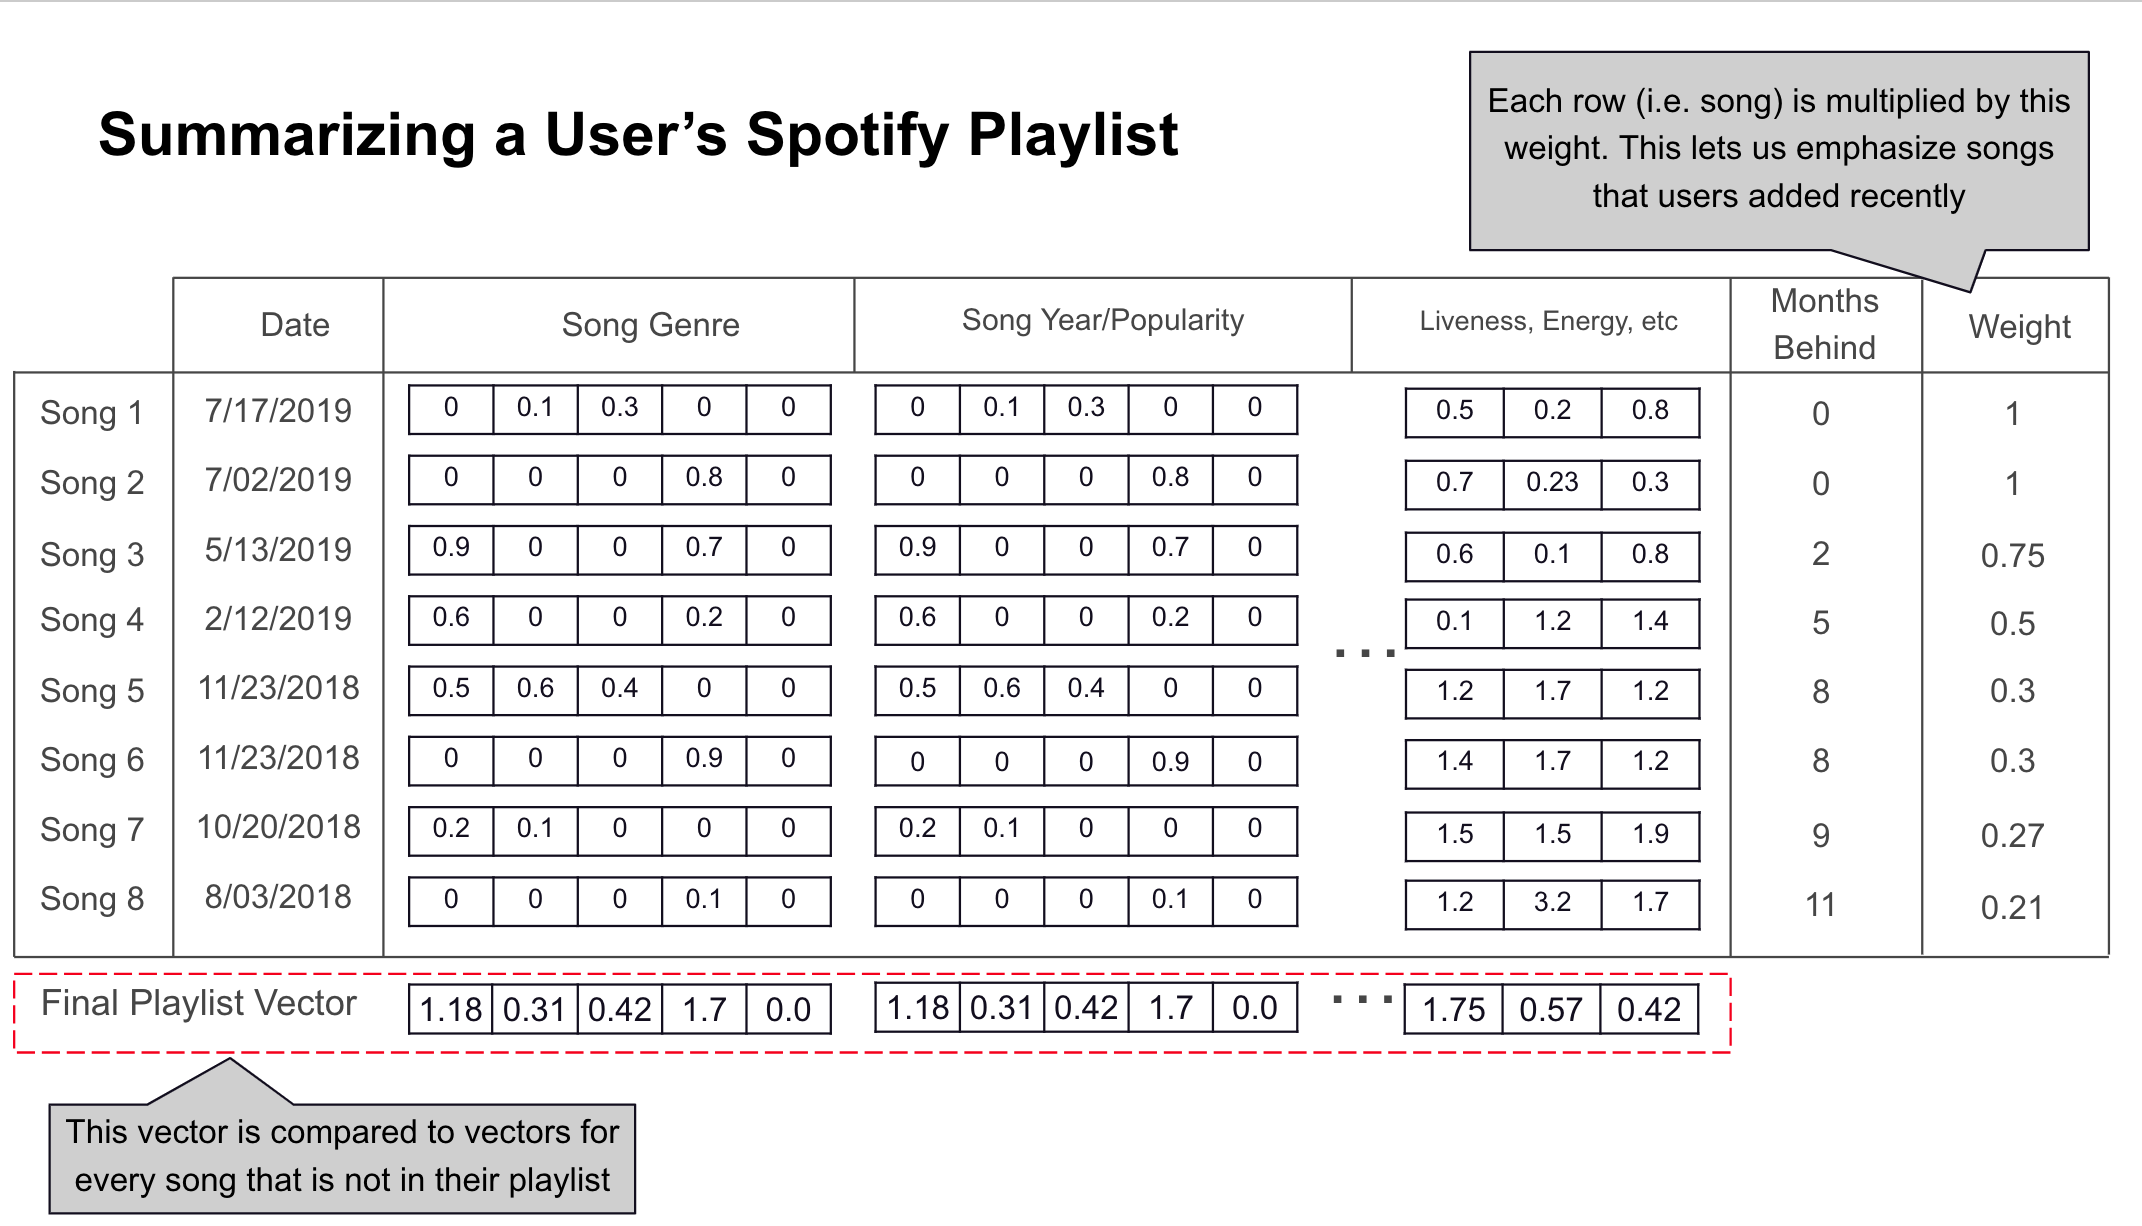

In [100]:
from IPython.display import Image
Image("C:/Users/Admin/Desktop/spotify-recommendation-system-main/summarization_2.png")

In [101]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [102]:
#complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_EDM, 1.09)
complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [82]:
complete_feature_set_playlist_vector_EDM.shape
complete_feature_set_playlist_vector_chill.shape

(3329,)

## 5. Generate Recommendations

In [83]:
from IPython.display import Image
#Image("/Users/thakm004/Documents/Spotify/cosine_sim_2.png")

In [84]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [85]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [86]:
from IPython.display import Image
#Image("/Users/thakm004/Documents/Spotify/spotify_results.png")

In [87]:
edm_top40

acousticness                                            artists  \
27053       0.005200                                           ['Teho']   
79653       0.092700                  ['Kungs', "Cookin' On 3 Burners"]   
50992       0.951000                                  ['Petit Biscuit']   
50991       0.729000                                  ['Petit Biscuit']   
79652       0.087400                  ['Kungs', "Cookin' On 3 Burners"]   
37981       0.036100                   ['Set Mo', 'Fractures', 'Moods']   
79872       0.014400        ['Kraak & Smaak', 'Cleopold', 'James Curd']   
26648       0.444000                                      ['Tez Cadey']   
3669        0.360000            ["Opetaia Foa'i", 'Lin-Manuel Miranda']   
79272       0.016200                                ['La La Land Cast']   
56152       0.024700  ['Ofenbach', 'Quarterhead', 'Norma Jean Martine']   
58920       0.003730                                    ['Nathan Palm']   
58847       0.002210                                        ['Nayrobi']   
58848       0.002210                                        ['Nayrobi']   
130939      0.000467         ['Cristian Poow', 'Fine Touch', 'Valessa']   
152778      0.812000                                  ['Andreas Weise']   
145942      0.000857                   ['Beny Ramirez', 'David Ardila']   
14841       0.017300                                         ['Tileff']   
146990      0.001510                                     ['Bass Monta']   
3946        0.004690                                        ['Zu Tief']   
108580      0.000084                               ['Gametightelectro']   
75128       0.000285                                       ['Linemoon']   
122960      0.001250                             ['Dubbtone', 'Tileff']   
7855        0.021300                                         ['Wicket']   
134172      0.000050                                      ['Chri5Beat']   
154636      0.000205                                ['Alejandro Dario']   
8144        0.000873                                      ['WesStraub']   
114846      0.005140                                          ['Fobos']   
57569       0.000359                                    ['Nikola Gala']   
108562      0.000223                               ['Gametightelectro']   
65844       0.032300                             ['Maurizio Gubellini']   
115517      0.000754                                         ['FiveAm']   
108569      0.006470                               ['Gametightelectro']   
65848       0.000122                             ['Maurizio Gubellini']   
57788       0.000414                    ['Nick Panlook', 'Chris Johns']   
63603       0.000818                                      ['Mikalogic']   
65847       0.057400              ['Maurizio Gubellini', 'Mia Crispin']   
108575      0.000400                               ['Gametightelectro']   
117934      0.000377              ['Erika Halliday', 'Ricardo Galindo']   
71995       0.013200                                      ['Lounge 50']   

        danceability  duration_ms  energy  explicit                      id  \
27053          0.640       519885   0.767         0  1UUuYmFFFQGmXwUlGngutx   
79653          0.792       195547   0.717         0  1A8j067qyiNwQnZT0bzUpZ   
50992          0.411       391257   0.364         0  5LLtNp8qc3NaCIieZ2W4Dk   
50991          0.783       237793   0.467         0  0hNduWmlWmEmuwEFcYvRu1   
79652          0.792       195561   0.703         0  5CK38mZNM3jSpjLNZVcXmL   
37981          0.667       239250   0.489         0  5xnJYVv75X8OqiZtSdMLGQ   
79872          0.800       424355   0.697         0  1ZeraF2ReWLUrp7jnBIEzd   
26648          0.740       210853   0.831         0  6UqRGwjwYL0stXbaodTxwo   
3669           0.689       141413   0.578         0  6YH2r9NyEJTjlRmKOCvxgJ   
79272          0.588       228173   0.742         0  5kRBzRZmZTXVg8okC7SJFZ   
56152          0.798       156960   0.828         0  14ngWWxvUS

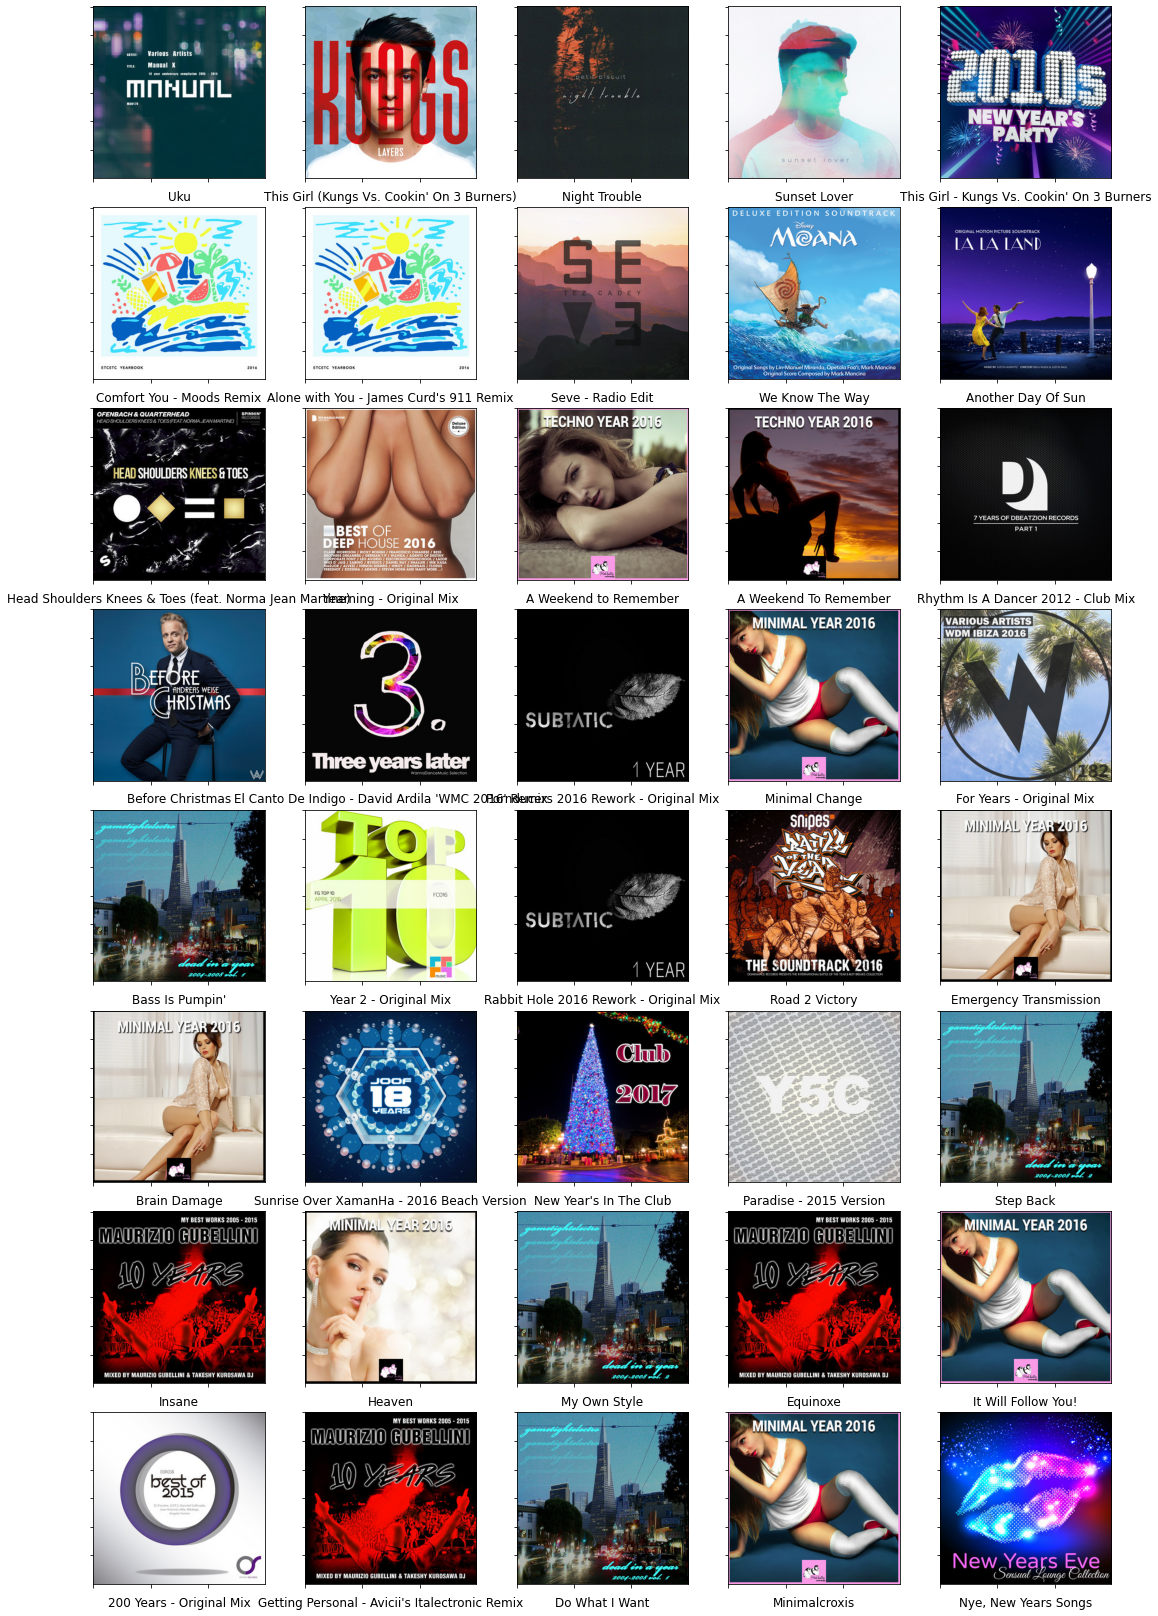

In [88]:
visualize_songs(edm_top40)

In [89]:
chill_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill)

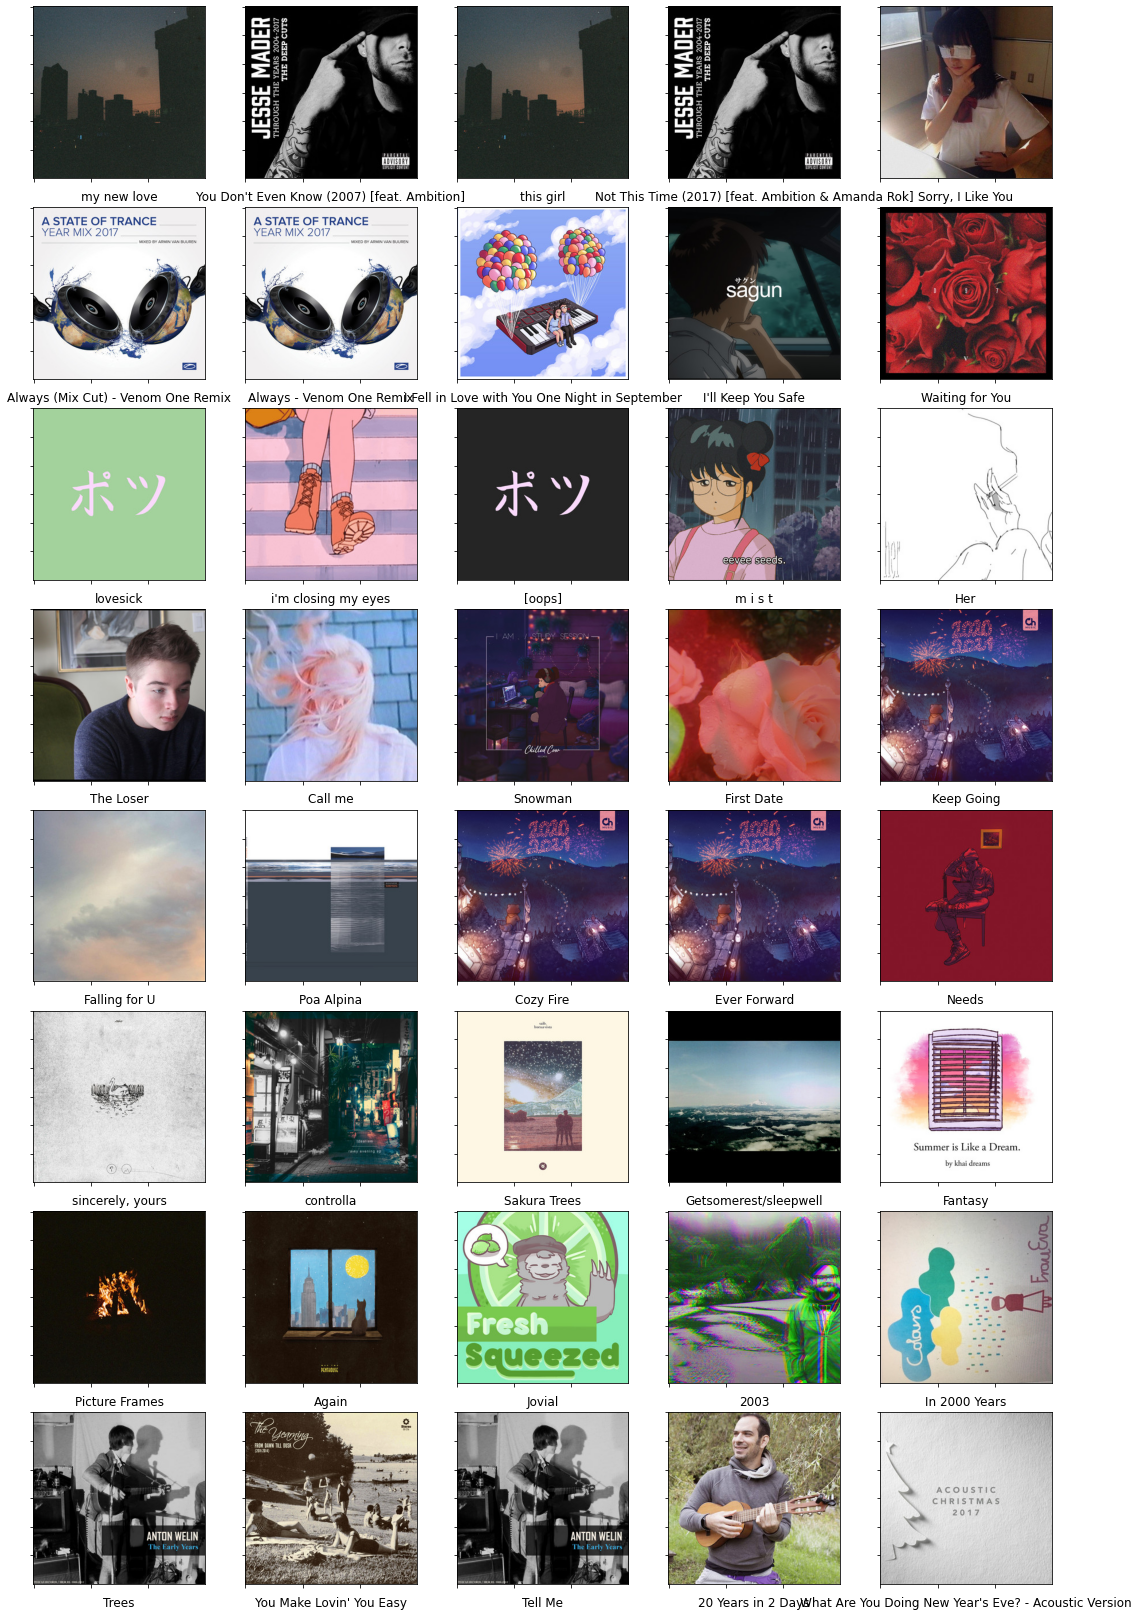

In [90]:
visualize_songs(chill_top40)